In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def predict_peaks(data, peaks):
    predictor = nsx.PeakPredictor(data)
    predictor._dmin = 2.0
    predictor._dmax = 50.0
    predictor._Isigma = 3.0
    predictor._minimumNeighbors = 20
    predictor._handler = nsx.ProgressHandler()
    return predictor.predictPeaks(False, peaks)
    
def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

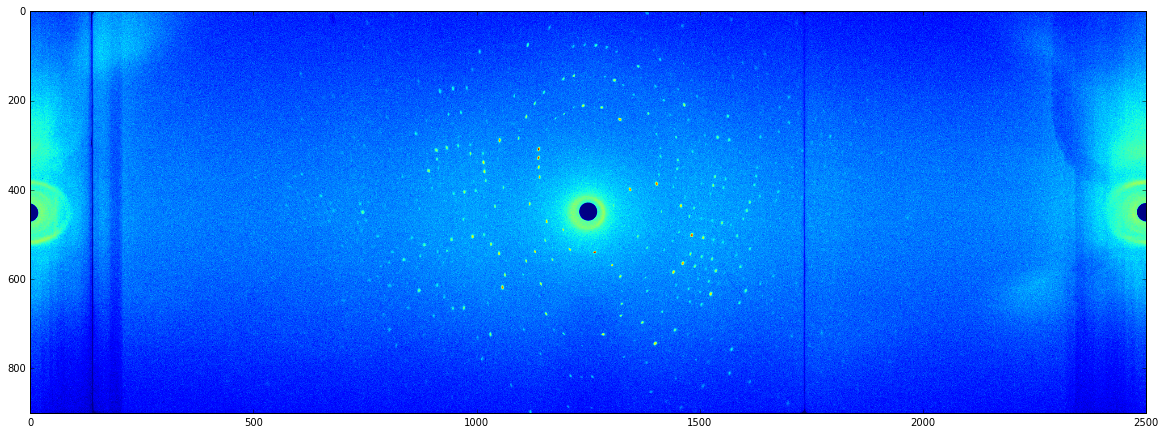

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [7]:
numors = nsx.vector_data()
numors.push_back(data)
peaks = finder.find(numors)
print(peaks.size())

9203


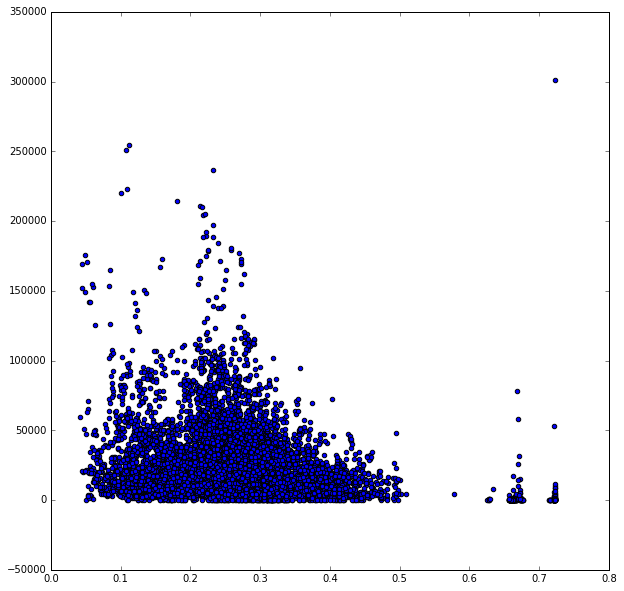

In [8]:
plot_I_vs_q(peaks)

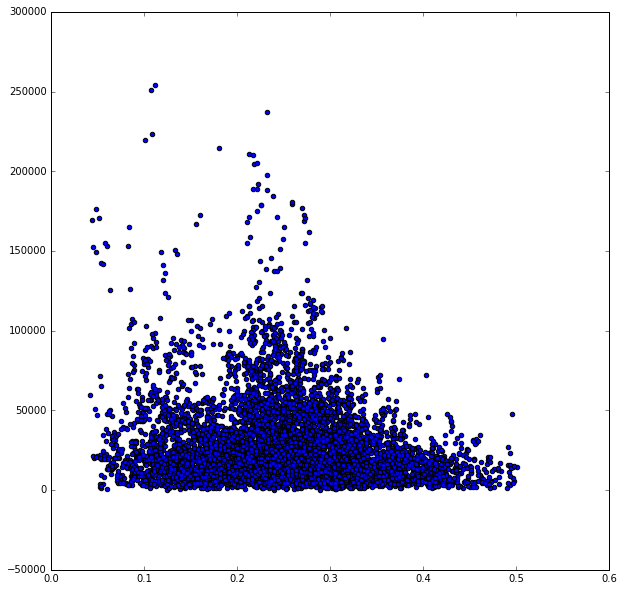

In [9]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
plot_I_vs_q(good_peaks)

In [10]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.getSample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = np.array([[0.,0.,0.]])
    if uc.getMillerIndices(peak.getQ(), hkl):
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 8104 peaks
indexed 7936 of 8104
found unit cell with parameters: 
a:  57.00153499803729
b:  60.67647966511042
c:  69.2271427000139
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948968


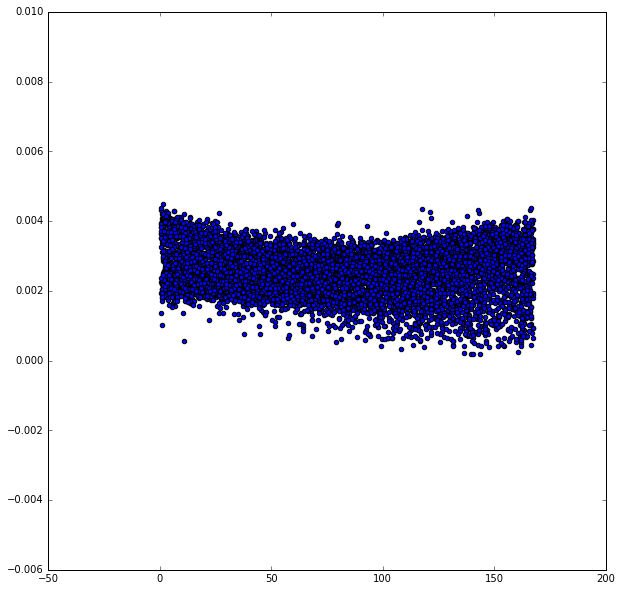

In [11]:
plot_dq_vs_frame(indexed_peaks)

In [12]:
nbatches = int(data.getNFrames() / 15)
states = data.getInstrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


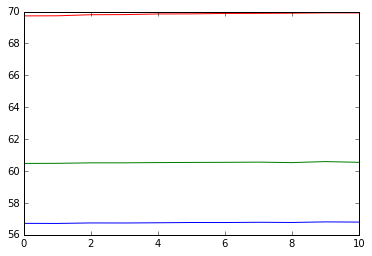

In [13]:
abc = []

for b in refiner.batches():
    ch = b.cell().character()
    abc.append([ch.a, ch.b, ch.c])
    
plt.plot([a[0] for a in abc])
plt.plot([a[1] for a in abc])
plt.plot([a[2] for a in abc])
plt.show()

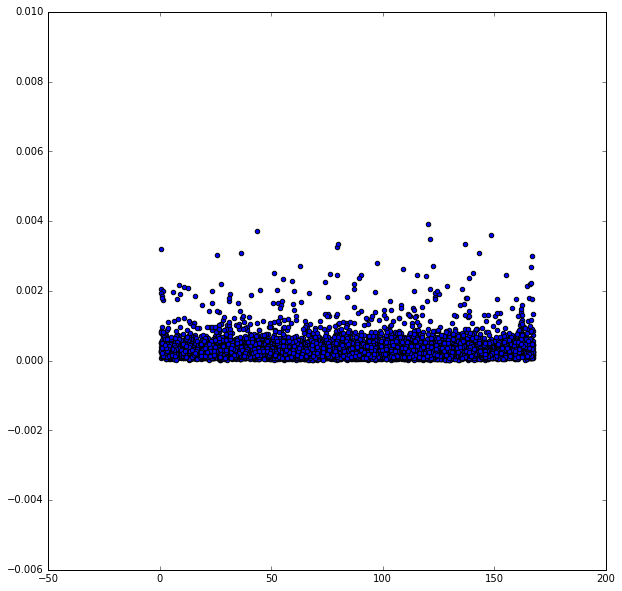

In [14]:
refined_peaks = reindex(indexed_peaks, refiner.batches())
plot_dq_vs_frame(refined_peaks)

sample orientation


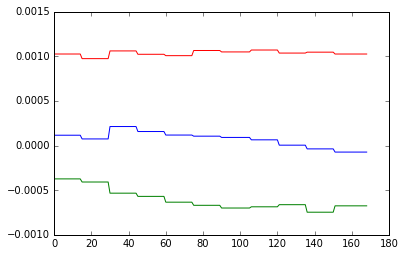

sample orientation perturbation


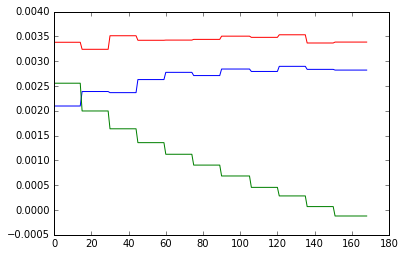

nx, ny


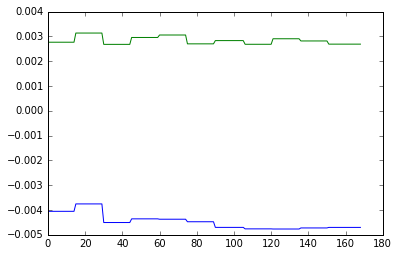

In [15]:
print("sample orientation")
plt.plot([state.samplePosition[0] for state in states])
plt.plot([state.samplePosition[1] for state in states])
plt.plot([state.samplePosition[2] for state in states])
plt.show()
    
print("sample orientation perturbation")
plt.plot([state.sampleOrientationOffset[0] for state in states])
plt.plot([state.sampleOrientationOffset[1] for state in states])
plt.plot([state.sampleOrientationOffset[2] for state in states])
plt.show()
    
print("nx, ny")
plt.plot([state.ni[0,0] for state in states])
#plt.plot([state.ni[0,1] for state in states])
plt.plot([state.ni[0,2] for state in states])
plt.show()

In [16]:
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9777262461078734,
 'CCtrue': 0.9943529032300169,
 'Rmeas': 0.07931185987406122,
 'Rmerge': 0.0634705364161554,
 'Rpim': 0.04660400227148977}

In [17]:
#predicted = predict_peaks(data, refined_peaks)
#predicted.size()

In [18]:
peak_set = nsx.PeakSet()

for peak in refined_peaks:
    peak_set.insert(peak)

In [19]:
data.integratePeaks(peak_set, 4.0, 10.0, False, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.8509259415116837,
 'CCtrue': 0.9588846327706179,
 'Rmeas': 0.15151553912074944,
 'Rmerge': 0.1215866768330517,
 'Rpim': 0.08856285214223335}

In [27]:
scale = 2.7
data.integratePeaks(peak_set, scale, 2*scale, False, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9578585608786755,
 'CCtrue': 0.9891793310529656,
 'Rmeas': 0.08829739390960419,
 'Rmerge': 0.0701329238861308,
 'Rpim': 0.052567403017250505}

In [21]:
refined_peaks[200].isSelected()

True